## Oscar Prediction Model Development

### Data Importing and Analysis

The following code imports the three csv files from the MentingWan/Oscar github repo

In [483]:
import torch
import pandas as pd

labels_url = "https://github.com/MengtingWan/oscar/raw/master/data/df_labels.csv"
features_url = "https://github.com/MengtingWan/oscar/raw/master/data/df_features.csv"
titles_url = "https://github.com/MengtingWan/oscar/raw/master/data/titles.json"
df_labels = pd.read_csv(labels_url)
df_features = pd.read_csv(features_url)
df_titles = pd.read_json(titles_url, lines=True)

The df_features and df_labels dataframes are 1:1 meaning that one row in `df_features` correlates to a row in `df_labels`, but that isn't the case for df_titles. I will need to do some data manipulation if I want to attach the features of df_titles to the `df_features` and `df_labels`

In [467]:
len(df_features), len(df_labels), len(df_titles)

(3645, 3645, 1655)

The first step to manipulating the data to attach the fields of the `df_titles` dataframe to the other others is to cleanup the `primaryNomineeCode` and `secondaryNomineeCode` fields. Doing this we can compare these fields to the `const` field of the `df_titles` dataframe to attach the genres and user/critic rating scores to `df_features` and `df_labels`

In [484]:
df_labels['primaryNomineeCode'] = df_labels['primaryNomineeCode'].str.slice(2,-2)
df_labels['primaryNomineeName'] = df_labels['primaryNomineeName'].str.slice(2,-2)
df_labels['secondaryNomineeCode'] = df_labels['secondaryNomineeCode'].str.slice(2,-2)
df_labels['secondaryNomineeName'] = df_labels['secondaryNomineeName'].str.slice(2,-2)
df_labels.head(5)

,eventName,eventId,year,awardName,categoryName,newCategoryName,primaryNomineeName,primaryNomineeCode,secondaryNomineeName,secondaryNomineeCode,awardNominationId,isWinner,string
0,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Daniel Day-Lewis,nm0000358,My Left Foot,tt0097937,an0052711,True,"{""primaryNominees"": [""nm0000358""], ""secondaryN..."
1,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Kenneth Branagh,nm0000110,Henry V,tt0097499,an0052712,False,"{""primaryNominees"": [""nm0000110""], ""secondaryN..."
2,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Morgan Freeman,nm0000151,Driving Miss Daisy,tt0097239,an0052714,False,"{""primaryNominees"": [""nm0000151""], ""secondaryN..."
3,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Robin Williams,nm0000245,Dead Poets Society,tt0097165,an0052715,False,"{""primaryNominees"": [""nm0000245""], ""secondaryN..."
4,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Tom Cruise,nm0000129,Born on the Fourth of July,tt0096969,an0052713,False,"{""primaryNominees"": [""nm0000129""], ""secondaryN..."


After cleaning up the data I loop through `df_labels` and `df_titles` comparing the "const" field to the "primaryNomineeCode" and "secondaryNominee" code like I mentioned in the above markdown field. The result of this is many of the user/critic ratings and genres associated with a films title are attached to their entry in `df_labels`

In [485]:
df_labels['user_rating'] = None
df_labels['critic_rating'] = None
df_labels['genre'] = None
user_ratings = []
critic_ratings = []
genres = []
new_label_df = df_labels.copy()
for data_row in df_labels.itertuples():
    appended = False
    for title_row in df_titles.itertuples():
        if ((title_row[1] == data_row[8]) or (title_row[1] == data_row[10])):
            user_ratings.append(title_row[5])
            critic_ratings.append(title_row[4])
            genres.append(title_row[3])
            appended = True

    if(not appended):
        user_ratings.append(None)
        critic_ratings.append(None)
        genres.append(None)

new_label_df['genre'] = genres
new_label_df['user_rating'] = user_ratings
new_label_df['critic_rating'] = critic_ratings
df_labels = new_label_df

The following code was produced later in my development process and moved further up for readability in my workflow. Here I am adding useful categories from the titles and labels dataframes to the features dataframe that was made in my first code block. After a little more data cleaning this `df_data` dataframe will be used for my model training

In [486]:
df_data = df_features
df_data['category'] = df_labels['newCategoryName']
df_data['genre'] = df_labels['genre']
df_data['year'] = df_labels['year']
df_data['label'] = df_labels['isWinner'].astype(int)
df_data['primary_nom'] = df_labels['primaryNomineeCode']
df_data['secondary_nom'] = df_labels['secondaryNomineeCode'] 
df_data['user_rating'] = df_labels['user_rating']
df_data['critic_rating'] = df_labels['critic_rating']
df_data = df_data.dropna()
df_data

,BAFTA Awards :: BAFTA Film Award :: Best Actor :: Winner,Golden Globes :: Golden Globe :: Best Performance by an Actor in a Motion Picture - Drama :: Nominated,National Society of Film Critics Awards :: NSFC Award :: Best Actor :: Winner,London Critics Circle Film Awards :: ALFS Award :: Actor of the Year :: Winner,Film Independent Spirit Awards :: Independent Spirit Award :: Best Foreign Film :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Actor in a Supporting Role :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Film :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Make Up Artist :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Screenplay (Adapted) :: Nominated,Writers Guild of America :: WGA Award (Screen) :: Best Screenplay Based on Material from Another Medium :: Nominated,...,numCriticReviews,metacriticScore,category,genre,year,label,primary_nom,secondary_nom,user_rating,critic_rating
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.225562,1.112700,Best Performance by an Actor in a Leading Role,"[Biography, Drama, Mystery]",1991,1,nm0000460,tt0100486,7.2,93.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.339425,0.927769,Best Performance by an Actor in a Leading Role,"[Comedy, Drama, History, Romance]",1991,0,nm0000367,tt0099334,7.5,79.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.457619,0.835303,Best Performance by an Actor in a Leading Role,"[Adventure, Drama, Western]",1991,0,nm0000126,tt0099348,8.0,72.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.097466,0.861722,Best Performance by an Actor in a Leading Role,"[Biography, Drama]",1991,0,nm0000134,tt0099077,7.8,74.0
10,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.038320,0.980455,Best Performance by an Actor in a Leading Role,"[Crime, Drama, Thriller]",1992,1,nm0000164,tt0102926,8.6,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.137966,1.061634,Best International Feature Film,"[Comedy, Drama, Thriller]",2020,1,tt6751668,,8.6,96.0
3636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.321398,0.836491,Best International Feature Film,[Drama],2020,0,tt8649186,,8.0,68.0
3637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.374268,0.946211,Best International Feature Film,"[Documentary, Drama]",2020,0,tt8991268,,8.1,86.0
3638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.096703,0.848682,Best International Feature Film,"[Crime, Drama, Thriller]",2020,0,tt10199590,,7.7,78.0


### Data Visualization

The following code was used to development some ideas about what features might have been paired together during the training of a logistic regression model

<Axes: xlabel='critic_rating', ylabel='user_rating'>

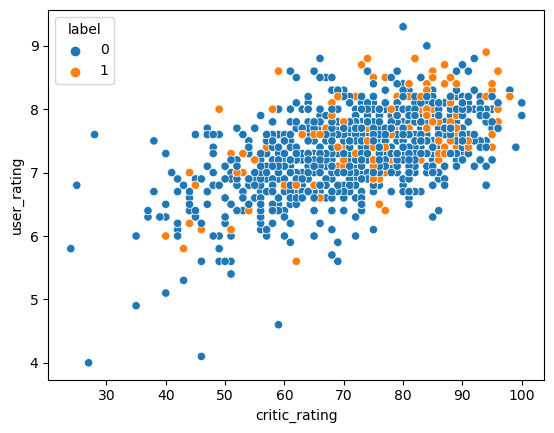

In [487]:
import seaborn as sns

data = df_data[['user_rating', 'critic_rating', 'label']]
sns.scatterplot(data=data, x = 'critic_rating', y = 'user_rating', hue='label')

<Axes: xlabel='user_rating', ylabel='category'>

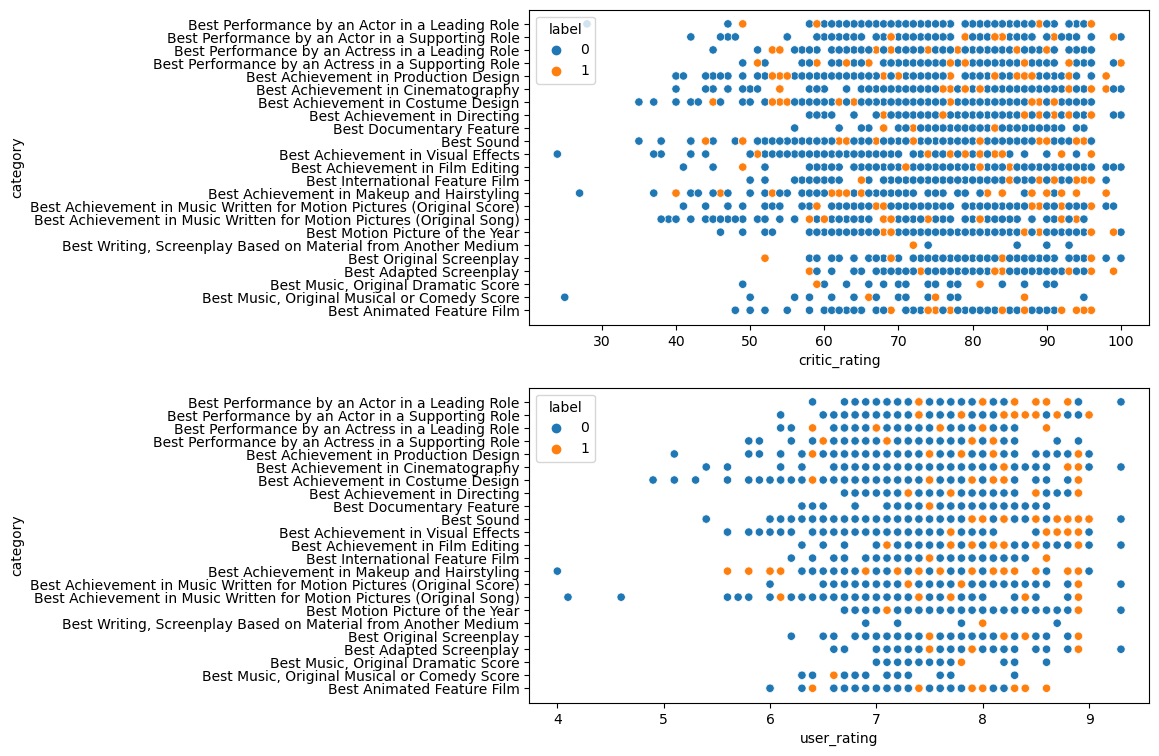

In [488]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(8, 9))
data = df_data[['critic_rating', 'category', 'label']]
sns.scatterplot(ax=ax[0], data=data, x = 'critic_rating', y = 'category', hue='label')
data = df_data[['user_rating', 'category', 'label']]
sns.scatterplot(ax=ax[1], data=data, x = 'user_rating', y = 'category', hue='label')

From the above three plots there doesn't seem to be any correlation between whether or not a nominee won an oscar and their user/rating score combination or their critic/nomination category as well as no correlation between category and user rating

#### Splitting Genres

The following code splits the genre columns of each entry in `df_data` into one dataframe entry for each genre in the list. As many entries in the df contain a list of genres associated with the film.

In [489]:
new_df = []

for row in df_data.itertuples():
    for genre in row[2272]:
        data_row = list(row)
        data_row[2272] = genre
        new_df.append(data_row)


genre_df = pd.DataFrame(new_df)
genre_df = genre_df.drop(0, axis = 1)
genre_df.columns = df_data.columns
genre_df.head(5)

,BAFTA Awards :: BAFTA Film Award :: Best Actor :: Winner,Golden Globes :: Golden Globe :: Best Performance by an Actor in a Motion Picture - Drama :: Nominated,National Society of Film Critics Awards :: NSFC Award :: Best Actor :: Winner,London Critics Circle Film Awards :: ALFS Award :: Actor of the Year :: Winner,Film Independent Spirit Awards :: Independent Spirit Award :: Best Foreign Film :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Actor in a Supporting Role :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Film :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Make Up Artist :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Screenplay (Adapted) :: Nominated,Writers Guild of America :: WGA Award (Screen) :: Best Screenplay Based on Material from Another Medium :: Nominated,...,numCriticReviews,metacriticScore,category,genre,year,label,primary_nom,secondary_nom,user_rating,critic_rating
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.225562,1.112700,Best Performance by an Actor in a Leading Role,Biography,1991,1,nm0000460,tt0100486,7.2,93.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.225562,1.112700,Best Performance by an Actor in a Leading Role,Drama,1991,1,nm0000460,tt0100486,7.2,93.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.225562,1.112700,Best Performance by an Actor in a Leading Role,Mystery,1991,1,nm0000460,tt0100486,7.2,93.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.339425,0.927769,Best Performance by an Actor in a Leading Role,Comedy,1991,0,nm0000367,tt0099334,7.5,79.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.339425,0.927769,Best Performance by an Actor in a Leading Role,Drama,1991,0,nm0000367,tt0099334,7.5,79.0


<Axes: xlabel='user_rating', ylabel='genre'>

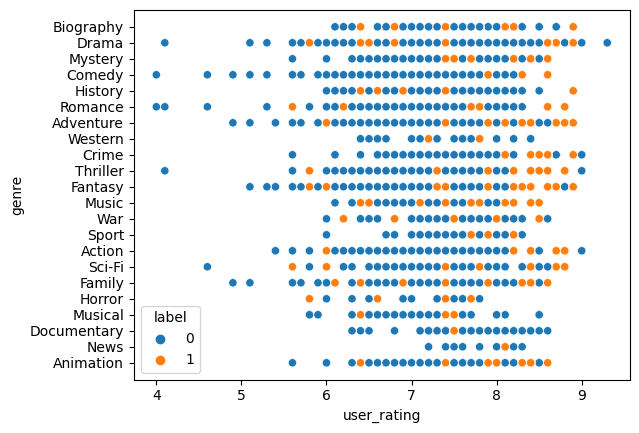

In [490]:
sns.scatterplot(data=genre_df[['genre', 'user_rating', 'label']], x='user_rating', y='genre', hue='label')

There seems to be a possible correlation between higher user ratings across many of the genres especially in the thriller genre and mystery, but this trend doesn't seem to be the most significant.

/Users/ethanlavallee/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ethanlavallee/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


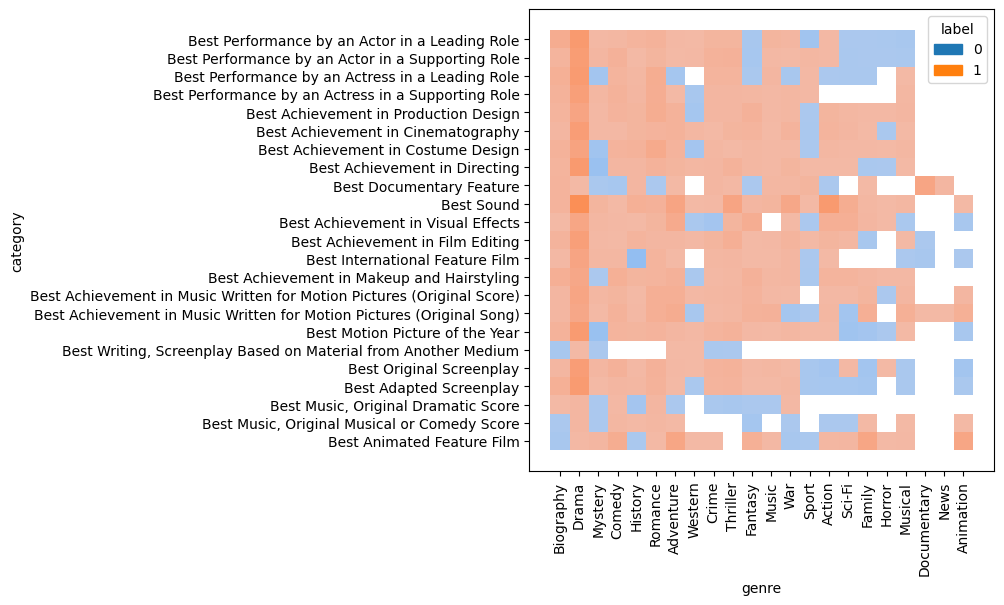

In [491]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(6,6))

sns.histplot(ax=axs, data=genre_df[['genre', 'category', 'label']], x='genre', y='category', hue='label')
axs.tick_params(axis='x', rotation=90)

Above I have produced a histogram comparing genres and categories with winners. Some of the regions make sense, that an animated movie will be likely to win "Best Animated Feature Film" or that at drama might win "Best Motion Picture of the Year". There isn't a trend that is that significant from this plot other than almost all films with the Drama tag seem more likely to be winners.

In [492]:
genre_df.groupby('label').size()

label
0    6765
1    1855
dtype: int64

Here we are randomly sampling the data to ensure we have an even number of winners and losers in the data. As when I first was working with this data I saw an 80% accuracy, but that was because the data was made up of 80% losers and the model was just predicting loser every time.

In [493]:
rand_samp_df = genre_df.groupby('label').sample(1855)
rand_samp_df.groupby('label').count()
# rand_samp_df = df_data.groupby('label').sample(737)
# rand_samp_df.groupby('label').count()

,BAFTA Awards :: BAFTA Film Award :: Best Actor :: Winner,Golden Globes :: Golden Globe :: Best Performance by an Actor in a Motion Picture - Drama :: Nominated,National Society of Film Critics Awards :: NSFC Award :: Best Actor :: Winner,London Critics Circle Film Awards :: ALFS Award :: Actor of the Year :: Winner,Film Independent Spirit Awards :: Independent Spirit Award :: Best Foreign Film :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Actor in a Supporting Role :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Film :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Make Up Artist :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Screenplay (Adapted) :: Nominated,Writers Guild of America :: WGA Award (Screen) :: Best Screenplay Based on Material from Another Medium :: Nominated,...,numUserReviews,numCriticReviews,metacriticScore,category,genre,year,primary_nom,secondary_nom,user_rating,critic_rating
label,,,,,,,,,,,,,,,,,,,,,
0,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,...,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855
1,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,...,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855


In [495]:
featureNames = list(genre_df.columns)
# featureNames = list(df_data.columns)
featureNames.remove('label')
featureNames.remove('primary_nom')
featureNames.remove('secondary_nom')

The following code is the bulk of the model develop. I am using scikit's pipeline class, one hot encoder, and logistic regression to produce my model. Categorical data like the genre's and categories get passed through the one hot encoder and then the rest of the data is numerical so it gets sent to the logistic regression model. We are doing a simple train test split on this data data as well before model training.

In [496]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error


column_transformer = ColumnTransformer(
    transformers=[
        ('genre_ohe', OneHotEncoder(), ['genre']),
        ('category_ohe', OneHotEncoder(), ['category']),
    ],
    remainder='passthrough',
    sparse_threshold=0
)

pipeline = Pipeline([
    ('encoder', column_transformer),
    ('regressor', LogisticRegression(max_iter=5000))
])

train_df, test_df = train_test_split(rand_samp_df, test_size=0.2)
X_train = train_df[featureNames]
y_train = train_df['label']

X_test  = test_df[featureNames]
y_test  = test_df['label']

pipeline.fit(X_train, y_train)


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('genre_ohe', OneHotEncoder(),
                                                  ['genre']),
                                                 ('category_ohe',
                                                  OneHotEncoder(),
                                                  ['category'])])),
                ('regressor', LogisticRegression(max_iter=5000))])

We can see our training score to be ~86% which is higher than our baseline rate or 50%, but there is still room for error in this model.

In [497]:
pipeline.score(X_train, y_train)

0.863544474393531

When completing cross validation we got a score of 77% which is lower than our model score and leads me to conclude we are overfitting to our data this can be seen later when comparing our train/test prediction averages.

In [498]:
from sklearn.model_selection import cross_val_score
cv_scores_LR = cross_val_score(pipeline, X_train, y_train, cv = 5)
cv_scores_LR.mean()


0.7746009845503943

In [499]:
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.21428571428571427


On our training data we again have an 86% prediction accuracy, but on our testing data we have a 78% prediction accuracy which is surprising and impressive, but leads me to conclude we have overfit to our data, but I don't think that takes away from how impressed I am with this models ability to predict Oscar winners. However, my thoughts on the model changed a lot when I looked into the confusion matrix from my model.

In [500]:
train_preds = (1.0*(pipeline.predict(X_train) == y_train)).mean()
test_preds  = (1.0*(pipeline.predict(X_test) == y_test)).mean()

print(f'Train prediction success: {train_preds}')
print(f'Test prediction success: {test_preds}')

Train prediction success: 0.863544474393531
Test prediction success: 0.7857142857142857


Looking at the confusion matrix of my model is really disappointing, with really encouraging training and testing accuracies it pains me to see that we have such low true positive rates. Even though the true negative rate is almost 90% we have an 83% false positive rate. Meaning our model is predicting too many entries to be winners, but when it does choose loser it does so with fairly high accuracy.

In [501]:
from sklearn.metrics import confusion_matrix

train_predictions  = (1.0*(pipeline.predict(X_train) == y_train))
confusion_matrix(y_train, train_predictions, normalize="true")

array([[0.16587356, 0.83412644],
       [0.10754843, 0.89245157]])

This can further be seen when we compared the rate of predicted positives from the model to the actual data. In our model predicted data we're looking at a predicted positive rate of about 86%, but in our actual data positive classifications make up only 50% of the data.

In [503]:
preds = pd.DataFrame(train_predictions)
preds.sum()/len(preds), y_train.sum()/len(y_train)

(label    0.863544
 dtype: float64,
 0.5043800539083558)

In [509]:
X_train_copy = X_train.copy()
X_train_copy['preds'] = train_predictions
X_train_copy['actual'] = y_train

In [518]:
plot_data_neg = X_train_copy.loc[(X_train_copy['preds'] == 0.0) & (X_train_copy['actual'] == 0)]
plot_data_pos = X_train_copy.loc[(X_train_copy['preds'] == 1.0) & (X_train_copy['actual'] == 1)]

Text(0.5, 1.0, 'True Positives')

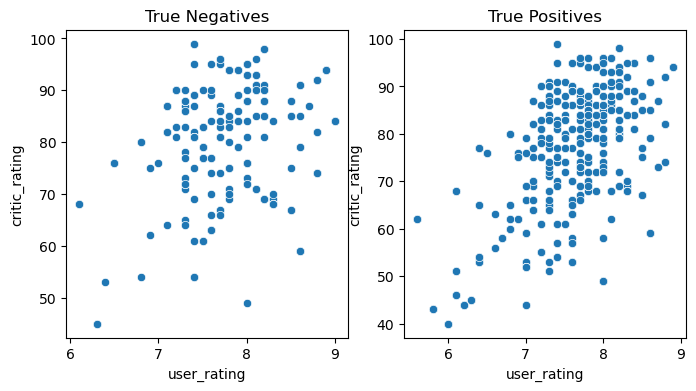

In [522]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
sns.scatterplot(ax=ax[0], data=plot_data_neg, x='user_rating', y='critic_rating')
sns.scatterplot(ax=ax[1], data=plot_data_pos, x='user_rating', y='critic_rating')
ax[0].set_title("True Negatives")
ax[1].set_title("True Positives")

There does seem like there might be some weight placed on the user and critic ratings, but my thought is that the negative predictions are most likely taken from the award values, that mostly make up the `df_feature` dataframe. If an entry in that DF has not one a single award the model can be quite sure that the film or actor/actress will not win an oscar as opposed to how high of a user/critic score they earned